# BUILDING A MODEL CAPABLE OF FILTERING USER COMMENTS BASED ON THE HARMFULNESS OF THE LANGUAGE

### Real Case Task:

Preprocess the text by removing the set of tokens that do not provide a significant semantic contribution.
Transform the text corpus into sequences and build a Deep Learning model comprising recurrent layers for a
multilabel classification task.
At prediction time, the model should return a vector containing a 1 or a 0 corresponding to each label present
in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-harmful comment
will be classified by a vector of only 0s [0,0,0,0,0,0]. Conversely, a dangerous comment will have at least one 1
among the 6 labels.

 INDEX
### 1. LIBRARIES AND DATA COLLECTION
    1.1 - Library
    1.2 - Data Ingestion
### 2. EDA - EXPLORATORY DATA ANALYSIS
    2.1 - Dataframe visualization
    2.2 - Data cleaning missing values, duplicates or aberrant
    2.3 - Feature engineering
    2.4 - Levels balancing analysis
### 3. DATA PREPROCESSING
    3.1 - Levels balancing
    3.2 - Text cleaning
    3.3 - Train-Validation-Test partitioning
    3.4 - Lemmatization, tokenization, sequencing and padding
### 4. MODEL
    4.1 - Base model definition
    4.2 - Compile
    4.3 - Fit
    4.4 - Model Evaluation
### 5. MODEL TEST AND IMPROVEMENT
    5.1 - Model test on random sentence
    5.2 - Improved Model test 
    5.3 - Improved model Evaluation
    5.4 - Improved model on random sentence



# 1. Data and library collection

### 1.1 Library

In [ ]:
pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Bidirectional, Dropout, LSTM, BatchNormalization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1.2 Data Ingestion

In [ ]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL + "Filter_Toxic_Comments_dataset.csv")

# 2. EDA - Exploratory Data Analysis

### 2.1 Dataframe visualization

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


### 2.2 Missing values Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


From a quick analysis with .info(), we notice that all the cells are filled. Now, let's verify that the values of the qualitative features are indeed always binary. The textual feature will not be subject to verification now because it can obviously contain any value, and the removal of irrelevant fractions will be addressed in the next steps.Da una rapida analisi con .info() notiamo che tutte le celle sono occupate. Ora verifichiamo che i valori delle feature qualitative siano effetivamente sempre binari. La feature testuale non sarà oggetto di verifiche ora perché può contenere ovviamente qualunque valore e la rimozione delle frazioni irrilevanti sarà oggetto dei prossimi punti.

In [ ]:
columns_to_check = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
def is_binary(column):
  return set(column).issubset({0,1})

In [ ]:
for column in columns_to_check:
  if is_binary(df[column]):
    print(f'Column {column} is binary')
  else:
    print(f'Caution: column {column} has aberrant values')

La colonna toxic è binaria
La colonna severe_toxic è binaria
La colonna obscene è binaria
La colonna threat è binaria
La colonna insult è binaria
La colonna identity_hate è binaria


### We have the confirmation that all quantitative features are complete and contain only binary values.

### 2.3 Feature engineering

Let's now create a feature that, unlike sum_injurious, is not simply the sum of the binary values of the qualitative features but concatenates them in order to identify the various combinations of hostile attributes present in the text dataset.Creiamo ora una feature che a differenza di sum_injurious non sia la semplice somma dei valori binari delle feature qualitative ma li concateni in modo da identificare le varie combinazioni di attributi ostili presenti nel dataset di testo.

In [ ]:
df['label_combination'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

### 2.4 Levels balancing analysis

In [ ]:
label_counts = df['label_combination'].value_counts()
print(label_counts)

label_combination
0_0_0_0_0_0    143346
1_0_0_0_0_0      5666
1_0_1_0_1_0      3800
1_0_1_0_0_0      1758
1_0_0_0_1_0      1215
1_1_1_0_1_0       989
1_0_1_0_1_1       618
0_0_1_0_0_0       317
0_0_0_0_1_0       301
1_1_1_0_1_1       265
0_0_1_0_1_0       181
1_1_1_0_0_0       158
1_0_0_0_0_1       136
1_0_0_0_1_1       134
1_0_1_1_1_0       131
1_0_0_1_0_0       113
1_1_1_1_1_0        64
1_0_1_1_1_1        56
0_0_0_0_0_1        54
1_1_0_0_0_0        41
1_0_1_0_0_1        35
1_1_1_1_1_1        31
0_0_0_0_1_1        28
0_0_0_1_0_0        22
0_0_1_0_1_1        18
1_0_0_1_1_0        16
1_1_0_0_1_0        14
1_0_1_1_0_0        11
1_1_0_1_0_0        11
1_0_0_1_0_1         7
1_1_0_0_1_1         7
1_1_1_0_0_1         6
1_1_1_1_0_0         4
0_0_0_1_1_0         3
1_0_0_1_1_1         3
1_1_0_0_0_1         3
0_0_1_0_0_1         3
0_0_1_1_0_0         2
0_0_1_1_1_0         2
1_1_0_1_1_0         1
1_1_0_1_0_1         1
Name: count, dtype: int64


Some classes are poorly represented, not even being able to accept a train-validation-test partitioning, so their oversampling is necessary.

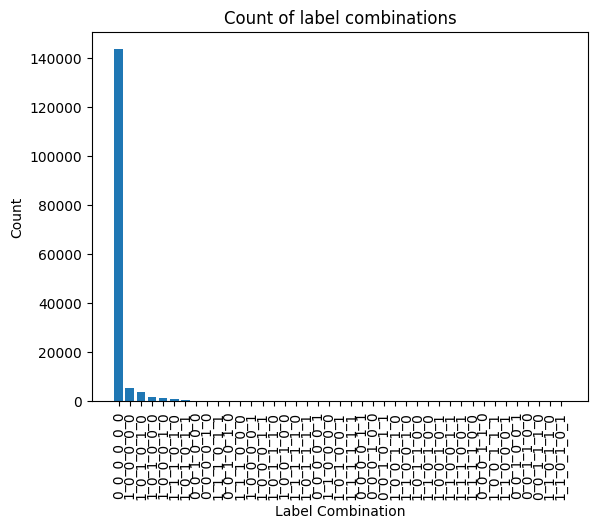

In [ ]:
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label Combination')
plt.ylabel('Count')
plt.title('Count of label combinations')
plt.xticks(rotation=90)
plt.show()

Non-hostile sentences are prevalent, and precisely

In [ ]:
non_hostile = (df['label_combination'] == '0_0_0_0_0_0').sum()
non_hostile

143346

In [ ]:
print('Non-hostile sentences are the {:.2f}% of the total'.format((non_hostile / df.shape[0]) * 100))

Le frasi non ostili sono lo 89.83% del totale


# 3. Data preprocessing

### 3.1 Levels balancing

Current hostile sentences

In [ ]:
hostile = (df.shape[0]) - non_hostile
hostile

16225

To balance the dataset, given the large number, we start by randomly but reproducibly sampling 16,225 instances from the non-hostile sentences. The decision to reduce the non-hostile fraction instead of oversampling the hostile part to balance the dataset is due to the limited computational capabilities of the machine on which the project is running.

In [ ]:
df_non_hostile = df[df['label_combination'] == '0_0_0_0_0_0'].sample(n=16225,
                                                    random_state=42)

In [ ]:
df_non_hostile.shape

(16225, 9)

New temporary dataframe

In [ ]:
df_hostile = df[df['label_combination'] != '0_0_0_0_0_0']
df_balanced = pd.concat([df_non_hostile, df_hostile])
df_balanced.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,label_combination
46733,"""\n\nOh, don't worry about me, Sandstein. I'm ...",0,0,0,0,0,0,0,0_0_0_0_0_0
110326,Are you trying to dispute that fact?,0,0,0,0,0,0,0,0_0_0_0_0_0
76687,SWOT analysis \n\nThis source – Align Technolo...,0,0,0,0,0,0,0,0_0_0_0_0_0
36231,"cover \n\nso, do we want a current or older co...",0,0,0,0,0,0,0,0_0_0_0_0_0
21514,P.S. It's probably worth setting up a template...,0,0,0,0,0,0,0,0_0_0_0_0_0


Let's now balance the levels of hostile sentences. We start by calculating what portion each level should have to total 16,225 instances overall.

In [ ]:
num_classes_hostile = df_hostile['label_combination'].nunique()
num_classes_hostile

40

In [ ]:
samples_per_class = df_non_hostile.shape[0] // num_classes_hostile
samples_per_class

405

Some levels have a higher number of instances and will need to be under-sampled, while the majority of hostile levels have a lower number and will need to be over-sampled. Let's start by identifying the hostile classes that have value_counts > 405.

In [ ]:
hostile_numbers = df_hostile['label_combination'].value_counts()
hostiles_to_undersample = hostile_numbers[hostile_numbers>samples_per_class].index.tolist()
hostiles_to_undersample

['1_0_0_0_0_0',
 '1_0_1_0_1_0',
 '1_0_1_0_0_0',
 '1_0_0_0_1_0',
 '1_1_1_0_1_0',
 '1_0_1_0_1_1']

In [ ]:
hostiles_to_oversample = hostile_numbers[hostile_numbers<samples_per_class].index.tolist()
hostiles_to_oversample

['0_0_1_0_0_0',
 '0_0_0_0_1_0',
 '1_1_1_0_1_1',
 '0_0_1_0_1_0',
 '1_1_1_0_0_0',
 '1_0_0_0_0_1',
 '1_0_0_0_1_1',
 '1_0_1_1_1_0',
 '1_0_0_1_0_0',
 '1_1_1_1_1_0',
 '1_0_1_1_1_1',
 '0_0_0_0_0_1',
 '1_1_0_0_0_0',
 '1_0_1_0_0_1',
 '1_1_1_1_1_1',
 '0_0_0_0_1_1',
 '0_0_0_1_0_0',
 '0_0_1_0_1_1',
 '1_0_0_1_1_0',
 '1_1_0_0_1_0',
 '1_1_0_1_0_0',
 '1_0_1_1_0_0',
 '1_1_0_0_1_1',
 '1_0_0_1_0_1',
 '1_1_1_0_0_1',
 '1_1_1_1_0_0',
 '0_0_0_1_1_0',
 '1_0_0_1_1_1',
 '1_1_0_0_0_1',
 '0_0_1_0_0_1',
 '0_0_1_1_0_0',
 '0_0_1_1_1_0',
 '1_1_0_1_1_0',
 '1_1_0_1_0_1']

Proceed with hostiles_to_undersample undersampling

In [ ]:
undersampled_data = []
oversampled_data = []

In [ ]:
for cls in hostiles_to_undersample:
    cls_data = df_hostile[df_hostile['label_combination'] == cls]
    undersampled_data.append(cls_data.sample(n=405, random_state=42))

Oversampling hostiles_to_oversample

In [ ]:
for cls in df_hostile['label_combination'].unique():
    if cls not in hostiles_to_undersample:
        cls_data = df_hostile[df_hostile['label_combination'] == cls]
        if len(cls_data) <= 405:
            n_repeats = 405 // len(cls_data)
            remainder = 405 % len(cls_data)
            oversampled_data.append(pd.concat([cls_data] * n_repeats + [cls_data.sample(n=remainder, random_state=42)]))
        else:
            undersampled_data.append(cls_data.sample(n=405, random_state=42))

Combine over and under sampled data

In [ ]:
df_hostile_balanced = pd.concat(undersampled_data + oversampled_data)

Combine balanced hostile and non-hostile sentences in the new df

In [ ]:
df_resampled = pd.concat([df_non_hostile, df_hostile_balanced])
y_resampled = pd.concat([df_non_hostile[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], df_hostile_balanced[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]])

Extract a row for a quick check

In [ ]:
df_resampled.iloc[18000]

,16383
comment_text,"""\n\nFUCK YOU YOU CUNT I HAD A WHOLE DOCUMENTA..."
toxic,1
severe_toxic,1
obscene,1
threat,0
insult,1
identity_hate,0
sum_injurious,4
label_combination,1_1_1_0_1_0


Check that y are equally partitioned between hostile and non-hostile, and that the hostile are balanced internally

In [ ]:
y_resampled.value_counts()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                16225
1      0             1        0       0       1                  405
                                      1       1                  405
                              1       0       0                  405
                                      1       0                  405
                                              1                  405
       1             0        0       0       0                  405
                                              1                  405
                                      1       0                  405
                                              1                  405
                              1       0       0                  405
                                              1                  405
                                      1       0                  405
                     1        0       0       0                  405
                                              1                  405
                                      1       0                  405
                                              1                  405
                              1       0       0                  405
                                      1       0                  405
       0             1        0       1       0                  405
                                      0       0                  405
0      0             0        0       0       1                  405
1      0             0        1       1       1                  405
0      0             0        0       1       0                  405
                                              1                  405
                              1       0       0                  405
                                      1       0                  405
                     1        0       0       0                  405
                                              1                  405
                                      1       0                  405
                                              1                  405
                              1       0       0                  405
                                      1       0                  405
1      0             0        0       0       0                  405
                                              1                  405
                                      1       0                  405
                                              1                  405
                              1       0       0                  405
                                              1                  405
                                      1       0                  405
       1             1        1       1       1                  405
Name: count, dtype: int64

### 3.2 Text Cleaning

Now that the dataframe is balanced, we can begin with the actual delivery of the project. Let's start with text cleaning using a function to convert text to lowercase and remove characters that are not relevant to the model.

In [ ]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'$$.*?$$', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    return text

Function application to balanced dataframe

In [ ]:
df_resampled['comment_text'] = df['comment_text'].apply(text_preprocessing)

### 3.3 Train-Validation-Test partitioning

Partitioning of temporary train set and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled['comment_text'], y_resampled, test_size=0.2, random_state=42, stratify = df_resampled['label_combination'])

Partitioning real train set and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify = y_train.apply(lambda row: '_'.join(row.astype(str)), axis=1))

### 3.4 Lemmatization, tokenization, sequencing and padding

Lemmatizer, lemmatizing function and tokenizer initialization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
tokenizer = Tokenizer(num_words=10000)

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

Preprocessing, lemmatization and tokenization function to use at the end of the process of a random sentence

In [ ]:
def preprocess_single_text(text):
    # Text Preprocessing
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'$$.*?$$', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)

    # Lemmatization
    text = lemmatize_text(text)

    # Tokenization and Padding
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    return padded_sequence

We apply the lemmatize function to the train, validation, and test sets because in this case, there isn't a true fit, so it is possible to do it. This is different from what will be done with the Keras Tokenizer, which should only be applied to the train set.

In [ ]:
X_train_lemmatized = X_train.apply(lemmatize_text)
X_val_lemmatized = X_val.apply(lemmatize_text)
X_test_lemmatized = X_test.apply(lemmatize_text)

In [ ]:
tokenizer.fit_on_texts(X_train_lemmatized)

Lemmatization has been performed on all three sets, and now it is possible to proceed with tokenization using Keras. The choice of Keras is necessary since the data will be fed into a neural network, otherwise deterministic tokenization with nltk could have been used. This is also the reason why the Keras Tokenizer fit is applied only to the training set, because it is a true fit, unlike the nltk tokenize which, not being a fit, could and should have been applied as a transformation to all three sets: train, validation, and test.

Sequencing

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train_lemmatized)
X_val_seq = tokenizer.texts_to_sequences(X_val_lemmatized)
X_test_seq = tokenizer.texts_to_sequences(X_test_lemmatized)

Sequence padding, first calculate maxlen as median of the existing lengths

In [ ]:
sequences_length = []
for seq in X_train_seq:
  sequences_length.append(len(seq))

In [ ]:
max_len = int(np.median(sequences_length))
print(max_len)

30


In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
corpus = X_train
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
sequences_lengths = [len(seq) for seq in sequences]
max_len = int(np.median(sequences_lengths))
print(max_len)

Definiamo il vocab_size

In [ ]:
vocab_size = len(tokenizer.word_index) +1
print(vocab_size)

42840


# 4 Model

### 4.1 Base model definition

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 4.2 Compile

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 4.3 Fit

In [ ]:
history = model.fit(X_train_pad, y_train, epochs = 10, batch_size=32, validation_data =(X_val_pad, y_val))

Epoch 1/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - accuracy: 0.4353 - loss: 0.4095 - val_accuracy: 0.3508 - val_loss: 0.1610
Epoch 2/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 134s 207ms/step - accuracy: 0.4662 - loss: 0.1683 - val_accuracy: 0.3626 - val_loss: 0.1249
Epoch 3/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 132s 204ms/step - accuracy: 0.4345 - loss: 0.1216 - val_accuracy: 0.3975 - val_loss: 0.1121
Epoch 4/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.4931 - loss: 0.0977 - val_accuracy: 0.4514 - val_loss: 0.1107
Epoch 5/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 144s 208ms/step - accuracy: 0.4814 - loss: 0.0806 - val_accuracy: 0.4657 - val_loss: 0.1177
Epoch 6/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 133s 204ms/step - accuracy: 0.4663 - loss: 0.0721 - val_accuracy: 0.4192 - val_loss: 0.1238
Epoch 7/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 142s 204ms/step - accuracy: 0.4999 - loss: 0.0670 - val_accuracy: 0.4792 - val_loss: 0.1239
Epoch 8/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5365 - l

### 4.4 Model Evaluation

In [ ]:
evaluation = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6169 - loss: 0.1732
Test Loss: 0.16833093762397766, Test Accuracy: 0.616962194442749


# 5. Model test and improvement

### 5.1 Test on random sentence

In [ ]:
sample_index = 100
sample_text = X_test.iloc[sample_index]
sample_true_labels = y_test.iloc[sample_index]

In [ ]:
preprocessed_text = preprocess_single_text(sample_text)
predicted_labels = model.predict(preprocessed_text)[0]
predicted_labels_binary = (predicted_labels >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


In [ ]:
print(f"Text: {sample_text}")
print(f"True Labels: {sample_true_labels.values}")
print(f"Predicted Labels: {predicted_labels_binary}")

Text: how bout you fuck off
True Labels: [1 1 1 0 0 0]
Predicted Labels: [1 1 1 0 0 0]


### 5.2 Test of improved base model

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(LSTM(128))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(y_train.shape[1], activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_val_pad, y_val))

Epoch 1/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 139s 205ms/step - accuracy: 0.3955 - loss: 0.4550 - val_accuracy: 0.3477 - val_loss: 0.2814
Epoch 2/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 135s 207ms/step - accuracy: 0.4271 - loss: 0.2754 - val_accuracy: 0.4767 - val_loss: 0.2024
Epoch 3/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 141s 206ms/step - accuracy: 0.4691 - loss: 0.2120 - val_accuracy: 0.4721 - val_loss: 0.1630
Epoch 4/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 145s 210ms/step - accuracy: 0.4750 - loss: 0.1708 - val_accuracy: 0.3855 - val_loss: 0.1366
Epoch 5/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 139s 207ms/step - accuracy: 0.4761 - loss: 0.1400 - val_accuracy: 0.6372 - val_loss: 0.1189
Epoch 6/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 142s 208ms/step - accuracy: 0.5011 - loss: 0.1231 - val_accuracy: 0.8375 - val_loss: 0.1210
Epoch 7/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 132s 203ms/step - accuracy: 0.5690 - loss: 0.1075 - val_accuracy: 0.5478 - val_loss: 0.1079
Epoch 8/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 134s 207ms/step - accuracy: 0.5424 -

### 5.3 Improved model Evaluation

In [ ]:
evaluation2 = model2.evaluate(X_test_pad, y_test)
print(f'Test Loss: {evaluation2[0]}, Test Accuracy: {evaluation2[1]}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8775 - loss: 0.2003
Test Loss: 0.19627849757671356, Test Accuracy: 0.8808018565177917


### 5.4 Test on random sentence

In [61]:
preprocessed_text = preprocess_single_text(sample_text)
predicted_labels = model2.predict(preprocessed_text)[0]
predicted_labels_binary = (predicted_labels >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [62]:
print(f"Text: {sample_text}")
print(f"True Labels: {sample_true_labels.values}")
print(f"Predicted Labels: {predicted_labels_binary}")

Text: how bout you fuck off
True Labels: [1 1 1 0 0 0]
Predicted Labels: [1 1 1 0 1 0]


More Epochs and fine tuning would provide further accuracy above the current 88%